In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/raf_pc/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

# Working environment
temp_repo_dir = "/home/raf_pc/Kemal/Temp"
data_repo_dir = "/home/raf_pc/Kemal/Data"

# SAM files for ribosome stalling data and coco assembly data
spt = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_TT1.sam", "60mer_TT2.sam"]]
sps = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_Rep1.sam", "60mer_Rep2.sam", "60mer_NoPK.sam"]]

# Exculude the gene below because it has over-expression problem.
exclude_genes = ["ENSG00000160789"]

# Create the infrastructure object
I = Infrastructre(temp_repo_dir,
                  exclude_genes=exclude_genes,
                  riboseq_assign_at=-15,
                  riboseq_assign_to="best_transcript",
                  ensembl_release=102,
                  verbose=True, 
                  sixtymers=[spt, sps])

In [3]:
the_range = list(range(10,60))
trieal = I.riboseq_sixtymers.translatome.assign_for_defined_footprint_lengths(the_range, 32, I.protein_genome, I.gene_info)

In [9]:
ls = list()
for w in the_range:
    counter = 0
    for gene_id in trieal[30].keys():
        counter += np.sum(trieal[w][gene_id])
    ls.append(counter)

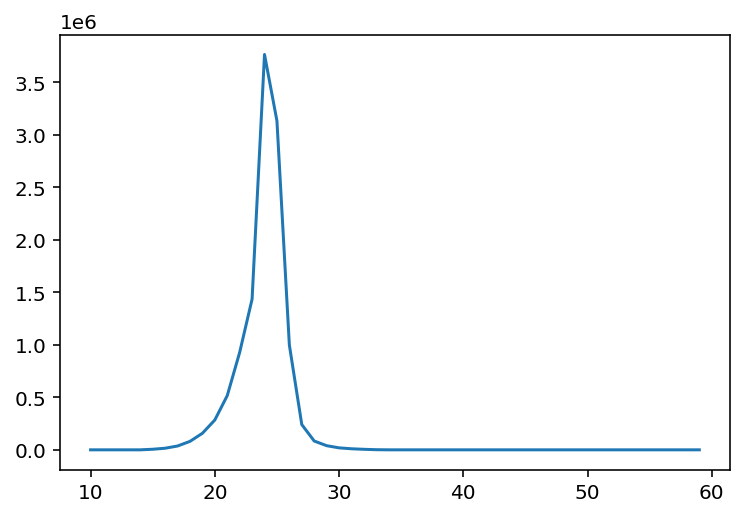

24

In [10]:
plt.plot(the_range, ls);plt.show()
ls.index(max(ls)) + min(the_range)

2132
2132
67


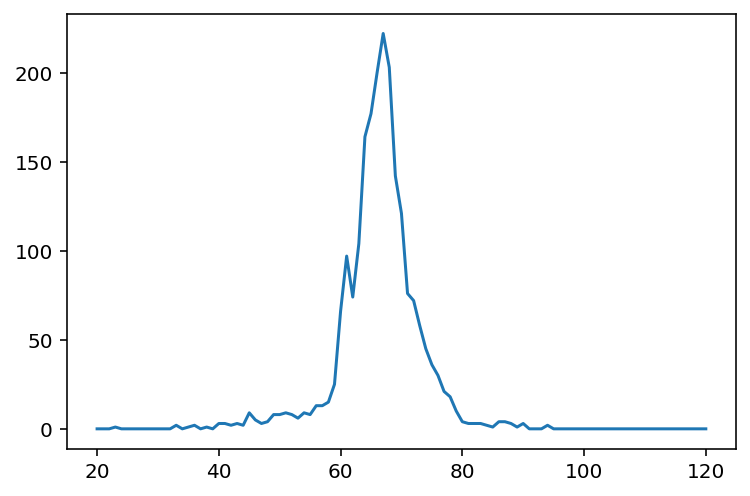

In [218]:
gene_id = I.gene_list[21]
print(np.sum(I.riboseq_sixtymers.experiment.gene_assignments[gene_id]))
k = np.array([np.sum(trieal[i][gene_id]) for i in list(range(20,121))])
print(np.sum(k))
print(k.argmax()+20)
plt.plot(range(20,121), k); plt.show()

In [228]:
trieal[67][gene_id][0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [8]:
the_range = list(range(10,60))

In [215]:
z = 63

y = max(I.riboseq_sixtymers.experiment.gene_lengths.values())
x = len(trieal[z])
arr60 = np.zeros((x,y))
for ind, gene_id in enumerate(trieal[z].keys()):
    sum_of_replicates = np.sum(trieal[z][gene_id], axis=0)[::-1]
    arr60[ind, 0:len(sum_of_replicates)] = sum_of_replicates
for mm in range(3):
    print(np.sum([num for ind, num in enumerate(np.sum(arr60, axis=0)) if ind % 3 == mm]))

138575.0
166954.0
108727.0


In [217]:
del arr60

In [161]:
len(np.sum(trieal[60][gene_id], axis=0))

1557